In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean 
%matplotlib inline

class Model():
    '''TODO add class description'''
    def __init__(self, nt, n0=50, L=5e6, H=1e3, beta=2e-11, k=0., mode=None):
        self.nt = nt                                                           # Number of timesteps 
        self.n0 = n0                                                           # Spatial resolution
        self.L = L                                                             # Horizontal basin length [m]
        self.H = H                                                             # Depth [m]
        self.beta = beta                                                       # Beta parameter
        self.k = k                                                             # Friction coefficient
        self.mode = mode                                                       # Time integration scheme
        # TODO add different time integration schemes
       # TODO Start from restart file (True/False)
        
        self.dx = L/n0                                                         # Zonal resolution [m]
        self.dy = self.dx                                                      # Meridional resolution [m]

        self.g = 9.81                                                          # m/s^2
        self.rho = 1025.                                                       # kg/m^3
        
        self.dtmax = self.dx/np.sqrt(self.g*self.H)                            # CFL criterion  
        
        self._calculate_fields()

    def _initialize_matix(self):
        for i in ['u_old','u_mid', 'u_new','v_old','v_mid', 'v_new','h_old','h_mid', 'h_new']: 
            setattr(self, i, np.zeros((self.n0+1, self.n0+1)))
        self.ke = np.empty(0)

    def _wind_forcing(self):
        self.tau0 = 1                                                           # Pa
        self.tx = [-self.tau0*np.cos(np.pi*y*self.dy/self.L) for y in range(self.n0)] 

    def _coriolis_parameter(self):
        self.f0 = 2*2*np.pi*np.sin(np.pi/4)/86400                               # Coriolis parameter at 45 degrees North
        self.f = [self.f0+ y*self.dy*self.beta for y in range(self.n0)]                  

    def _calculate_fields(self):

        self._initialize_matix()
        self._wind_forcing()
        self._coriolis_parameter()
        
        self.dt = np.floor((1/3)*self.dtmax)                                    # we set timestep as 1/3 of CFL
        
        for t in range(self.nt):
            
            for i in range(self.n0):
                for j in range(1, self.n0):
                    self.u_new[i,j] = self.u_old[i,j] + 2.*self.dt*(self.f[i]*(1/4.)*(self.v_mid[i+1,j-1]+self.v_mid[i+1,j] + self.v_mid[i,j-1] + self.v_mid[i,j]) - self.g*((self.h_mid[i,j]-self.h_mid[i,j-1])/self.dx) + self.tx[i]/(self.rho*self.H) - self.k*self.u_mid[i,j])
                    
            for i in range(1,self.n0):
                for j in range(self.n0):
                    self.v_new[i,j] = self.v_old[i,j] - 2*self.dt*(self.f[i]*(1/4)*(self.u_mid[i,j]+self.u_mid[i,j+1]+self.u_mid[i-1,j]+self.u_mid[i-1,j+1]) + self.g*((self.h_mid[i,j]-self.h_mid[i-1,j])/self.dy) + self.k*self.v_mid[i,j])              
        
            for i in range(self.n0):
                for j in range(self.n0):
                    self.h_new[i,j] = self.h_old[i,j]-2*self.dt*self.H*((self.u_mid[i,j+1]-self.u_mid[i,j])/self.dx + (self.v_mid[i+1,j]-self.v_mid[i,j])/(self.dy))
            
            tmp = 0
            for i in range(self.n0):
                for j in range(self.n0):
                    tmp += 0.5*(self.u_new[i,j]**2 + self.v_new[i,j]**2)
                    
            self.ke = np.append(self.ke, tmp/(self.n0**2))
            
            self.h_old = self.h_mid
            self.h_mid = self.h_new
            self.u_old = self.u_mid
            self.u_mid = self.u_new
            self.v_old = self.v_mid
            self.v_mid = self.v_new 
            
            day = 86400 # in sec
            self.t = t
            #TODO plot every specific timestep
        self.plot()
                
    def  plot(self):
        '''ploting ssh anf (u,v) fields'''
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4]) 
        fig = plt.figure(figsize=(14, 8))
        ax = fig.add_subplot(gs[0])
        plt.plot(self.tx, np.arange(50))
        plt.plot(np.zeros(50), np.arange(50), 'k--')
        for i in range(1, 50, 4):
            if i!=25:
                plt.arrow(0.0, i, self.tx[i], 0.0, fc="k", ec="k",shape='full', length_includes_head=True,
                        head_width=0.8, head_length=0.1)
        plt.ylim(0,50)
        plt.xlim(-1,1)
        plt.title('Wind stress [N/$m^2$]', fontsize=14)


        ax = fig.add_subplot(gs[1])

        cs = ax.contourf(self.h_new, cmap=cmocean.cm.balance,vmin=self.h_new.min(),vmax=self.h_new.max(), extend='both')
        cs1 = ax.contour(self.h_new, colors='k')
        ax.yaxis.set_visible(False) # This erases the y ticks
        #plt.clabel(cs1, colors='w', inline=1, inline_spacing=0, fontsize=10)
        ax.quiver(self.u_new, self.v_new, scale=5,units='width')
        cbar = plt.colorbar(cs)
        cbar.set_label('Sea surface height [m]', fontsize=14)
        cbar.solids.set_edgecolor("face")
        plt.title('Time = {:.0f} hours'.format(self.dt*self.t/3600), fontsize=14)
        fig.subplots_adjust(left=0, wspace=0.04, top=0.8)
        #save figure
        #fig.savefig('fplane{}.png'.format(self.t),dpi=100,bbox_inches='tight')
    
    def  plot1(self):
        '''ploting without wind subplot'''
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111)
        cs = ax.contourf(self.h_new, cmap=cmocean.cm.balance,vmin=self.h_new.min(),vmax=self.h_new.max(), extend='both')
        cs1 = ax.contour(self.h_new, colors='k')
        ax.quiver(self.u_new, self.v_new, scale=5,units='width')
        cbar = plt.colorbar(cs)
        cbar.set_label('Sea surface height [m]', fontsize=14)
        cbar.solids.set_edgecolor("face")
        plt.title('Time = {:.0f} hours'.format(self.dt*self.t/3600), fontsize=14)
        fig.savefig('fplane{}.png'.format(self.t),dpi=100,bbox_inches='tight')       

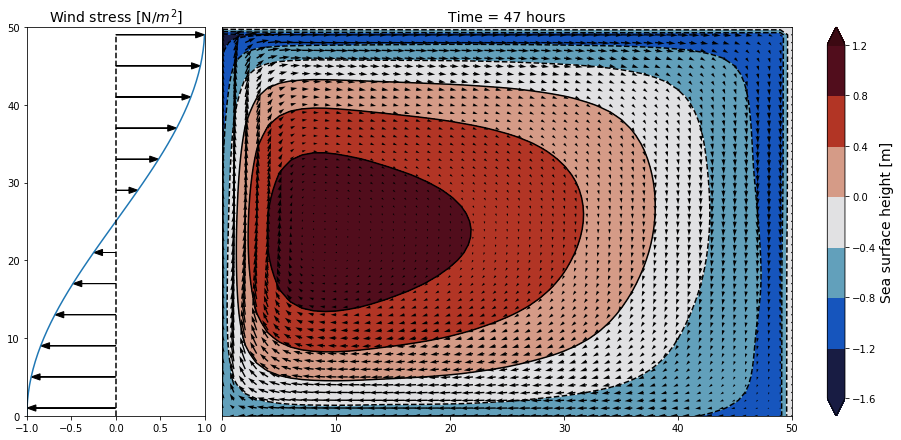

In [15]:
test1 = Model(nt=500)  
#test2 = Model(nt=1030, k=0.00001) 

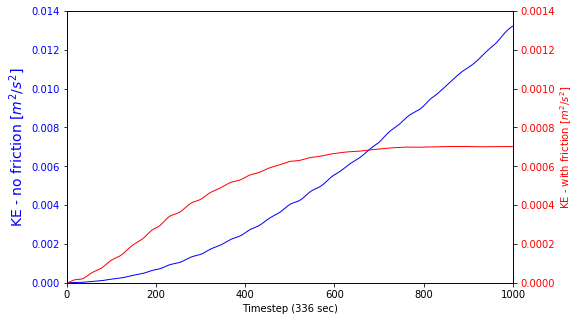

In [70]:
# model run for 1000 timesteps
test1 = Model(nt=1000)  
test2 = Model(nt=1000, k=0.00001) 
#create KE plot
fig = plt.figure(figsize=(8, 5))
# Plot y1 vs x in blue on the left vertical axis.
plt.xlabel("Timestep (336 sec)")
plt.ylabel("KE - no friction [$m^2/s^2$]", fontsize=14, color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.plot(test1.ke, "b-", linewidth=1)
plt.ylim(0.000, 0.014)
#plt.title("Temperature and Salinity from LOBO (Halifax, Canada)")
#fig.autofmt_xdate(rotation=50)
 
# Plot y2 vs x in red on the right vertical axis.
plt.twinx()
plt.ylabel("KE - with friction [$m^2/s^2$]", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(test2.ke, "r-", linewidth=1)
plt.ylim(0.0000, 0.0014)
plt.xlim(0, 1000)

#save figure
#fig.savefig('KE.png',dpi=100,bbox_inches='tight')